In [704]:
import pandas as pd
import cStringIO
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
%matplotlib inline

CPU times: user 470 ms, sys: 5.44 ms, total: 476 ms
Wall time: 474 ms
CPU times: user 527 ms, sys: 10.7 ms, total: 538 ms
Wall time: 533 ms


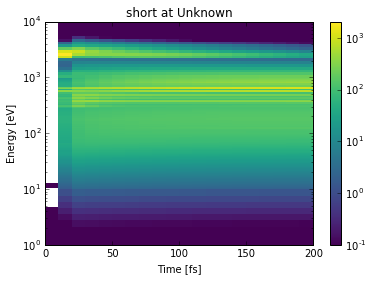

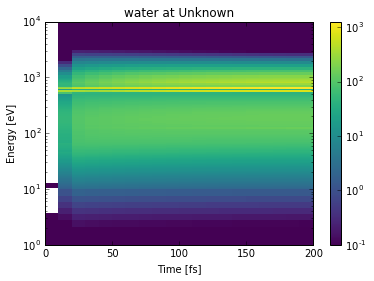

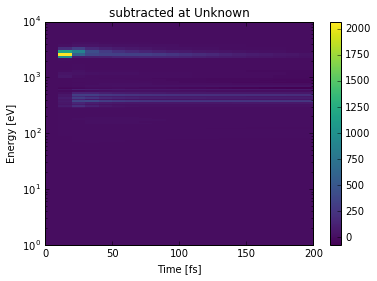

In [781]:
class Parser(object):
    '''
    Get the number of layers
    Get the number of timesteps
    Get the name of edits #the paramters
    
    Get the layer-dependent data
    Get the spectral data
    '''
    def __init__(self,filename,spectrum_keys=['SPECTRUM3'],save_list=['SPECTRUM3','r vs tiv']):
        self.filename=filename
        
        self.list_of_spectrum_keys=spectrum_keys
        self.aggregate_dictionary()
        self.save_list=save_list
        self.list_of_datablocks=[]
        
    def parse_file(self):
        '''Placeholder to actually go over the file and save the data'''

        with open(self.filename) as f:
            for line_index,line in enumerate(f):
                line=line.rstrip()
                if line.startswith('#'):
                    time=line.split()[3]
                    edit=str.join(' ', line.split()[5:])
                    self.list_of_datablocks.append(DataBlock(line_index,time,edit))
                elif line.startswith('$'):
                    self.list_of_datablocks[-1].add_descriptor_line(line.strip('$'))
                else:
                    self.list_of_datablocks[-1].add_line(line)

        for datablock in self.list_of_datablocks:
            datablock.cleanup()
                
    def stupid_output(self):
        '''A stupid function that simply print the original file line by line'''
        with open(self.filename) as f:
            for line in f:
                print line
    
    def create_spectrum(self,edit_str,energy_str='sp_energy',int_str='jsp'):
        temp_energybin=[]
        temp_intensity=[]
        for datablock_index,datablock in enumerate(self.list_of_datablocks):
            if datablock.edit==edit_str:
                temp_energybin.append(np.array(datablock.df['sp_energy'])[:,0])
                temp_intensity.append(np.array(datablock.df['jsp'])[:,0])
        return Spectrum(np.array(temp_energybin),np.array(temp_intensity),timesteps=self.timesteps_float)      
                    
    def aggregate_dictionary(self): 
        '''Reads the file to find the string that represent time'''

        full_list_of_edits=[]
        full_list_of_times=[]
        self.timesteps_str=[]
        self.edit_name_list=[]
        
        line_index_before=0
        line_diff=0
        line_diff_list=[]
        
    
        with open(self.filename) as f:
            for line_index,line in enumerate(f):
                if 'time' in line:
                    full_list_of_times.append(line.split()[3])
                    full_list_of_edits.append(str.join(' ', line.split()[5:]))

        for i in full_list_of_times:
            if i not in self.timesteps_str:
                self.timesteps_str.append(i)
                
        self.timesteps_float=[float(temp) for temp in self.timesteps_str]
                    
        for i in full_list_of_edits:
            if i not in self.edit_name_list:
                self.edit_name_list.append(i)
        
        with open(self.filename) as f:
            for line_index,line in enumerate(f):
                if 'time' in line:
                    #print '{0} found at line {1}'.format(line.split(),line_index)
                    full_list_of_times.append(line.split()[3])
                    full_list_of_edits.append(str.join(' ', line.split()[5:]))
                    for edit_index,edit in enumerate(self.edit_name_list):
                        if edit in line:
                            line_index_diff=line_index-line_index_before
                            line_index_before=line_index
                            line_diff_list.append(line_index_diff)
        
        self.edit_length_list=line_diff_list[1:len(self.edit_name_list)+1]
                
        self.edit_dict_list=[]
        
        for edit_index,edit_name in enumerate(self.edit_name_list):
            if self.edit_name_list[edit_index] in self.list_of_spectrum_keys:
                edit_type='spectral'
            else:
                edit_type='layered'
                self.number_of_layers=self.edit_length_list[edit_index]-3
            edit={'Name':self.edit_name_list[edit_index],'Length':self.edit_length_list[edit_index],'Type':edit_type,'Order':edit_index}
            self.edit_dict_list.append(edit)
            
class DataBlock(object):
    '''Datablock for text'''
    def __init__(self,lineindex,time,edit):
        self.lineindex=lineindex
        self.time=time
        self.edit=edit
        self.descriptor_lines=[]
        self.lines=[]
    def add_descriptor_line(self,line):
        '''Add a line that contain column descriptors'''
        self.descriptor_lines.append(line)
    def add_line(self,line):
        '''Add a line that contain actual data'''
        self.number_of_columns=len(line.split())
        self.lines.append(line)
    def cleanup(self):
        '''Method that is run after the whole datablock is saved'''
        self.is_layered_data = 'r' in self.descriptor_lines[0]
        self.one_row_descriptor=self.descriptor_lines[1]==''
        if self.one_row_descriptor:
            a=self.descriptor_lines[0]
            b="\n".join(self.lines)
            string_for_IO="\n".join([a,b])
            v = cStringIO.StringIO()
            v.write(string_for_IO)
            v.seek(0)
            self.df = pd.read_fwf(v)       
        else:
            a="\n".join(self.descriptor_lines)
            b="\n".join(self.lines)
            string_for_IO="\n".join([a,b])
            v = cStringIO.StringIO()
            v.write(string_for_IO)
            v.seek(0)
            self.df = pd.read_fwf(v, header=[0,1])

class Spectrum(object):
    '''Describes one spectrum'''
    def __init__(self,energybin_list,intensity_list,timesteps=None):
        self.energybin_list=energybin_list #a list
        self.energybins=self.energybin_list[0]
        self.intensity_list=intensity_list.T # a list
        #self.energy_range=[min(self.energybins),max(self.energybins)]
        #self.intensity_range=[min(self.intensity),max(self.intensity)]
        self.timesteps=timesteps
    def full_plot(self,material='Unknown',intensity='Unknown',fig=plt.figure()):
        time_fs=np.array(self.timesteps)*1e15
        plt.pcolormesh(time_fs,self.energybins,self.intensity_list,cmap='viridis',norm=LogNorm(vmin=0.1,vmax=self.intensity_list.max()))
        plt.title('{0} at {1}'.format(material,intensity))
        plt.xlabel('Time [fs]')
        plt.ylabel('Energy [eV]')
        plt.cbar=plt.colorbar()
        plt.gca().set_yscale('log')
        return fig
    def diff_plot(self,material='Unknown',intensity='Unknown',fig=plt.figure()):
        time_fs=np.array(self.timesteps)*1e15
        plt.pcolormesh(time_fs,self.energybins,self.intensity_list_diff,cmap='viridis')
        plt.title('{0} at {1}'.format(material,intensity))
        plt.xlabel('Time [fs]')
        plt.ylabel('Energy [eV]')
        plt.cbar=plt.colorbar()
        plt.gca().set_yscale('log')
        return fig    
    def subtract_background(self,spectrum):
        self.intensity_list_diff =  np.subtract(self.intensity_list,spectrum.intensity_list)
        #self.intensity_list_diff =  np.divide(np.subtract(self.intensity_list,spectrum.intensity_list),np.add(self.intensity_list,spectrum.intensity_list))
        
class Simulation(object):
    def __init__(self,file_path,material=None):
        self.a=4
        self.parser=Parser(file_path)
        %time self.parser.parse_file()
        self.timesteps=self.parser.timesteps_float
        self.number_of_layers=self.parser.number_of_layers
        self.spectrum=self.parser.create_spectrum('SPECTRUM3')
        


#my_sim=Simulation('run.plt')

short=Simulation('../../../../../Software/Emission/Analysis/RAWFROMTINTIN/100-fs/short/ener-7000/fl-1E20/run.plt')
plt.figure()
short.spectrum.full_plot(material='short')
water=Simulation('../../../../../Software/Emission/Analysis/RAWFROMTINTIN/100-fs/short_water/ener-7000/fl-1E20/run.plt')
plt.figure()
water.spectrum.full_plot(material='water')
short.spectrum.subtract_background(water.spectrum)
plt.figure()
short.spectrum.diff_plot(material='subtracted')


'1.5.1'

In [706]:
#temp_energybin=np.array(order=2)
#np.append(temp_energybin,[my_sim.parser.list_of_datablocks[-1].df['sp_energy']])
#np.array([i[0] for i in np.array(my_sim.parser.list_of_datablocks[-1].df['sp_energy'])])

#np.array(my_sim.parser.list_of_datablocks[-1].df['sp_energy'])[:,0]

In [728]:
energy=[]
intensity=[]
for blockindex,block in enumerate(my_sim.parser.list_of_datablocks):
    if block.edit=='SPECTRUM3':
        energy.append(block.df['sp_energy'].values)
        intensity.append(block.df['jsp'].values)

In [515]:
class Timestep(object):
    '''Describes one timestep'''
    def __init__(self,time,timeindex,**spectrum):
        self.time=time
        self.index=timeindex
        self.list_of_layers=layers
        self.spectrum=Spectrum(**spectrum)

class Spectrum(object):
    '''Describes one spectrum'''
    def __init__(self,energybins,intensity):
        self.energybins=energybins #a list
        self.intensity=intensity # a list
        self.energy_range=[min(energybins),max(energybins)]
        self.intensity_range=[min(intensity),max(intensity)]
        self._clean_spectrum = None


class Experiment(object):
    #list of simulations
    
    #method: create plots given a range of energies
    
    '''
    
    '''
    pass

class Simulation(object):
    def __init__(self):
        # Do parsing
        # create a list of timesteps
        #all the sim parameters
        pass
    def subtract():
        pass
    
class Layer(object):
    '''Describes one layer'''
    def __init__(self,name,composition,average_ionization,energybins,intensity,layer):
        self.name=name
        self.composition=composition
        self.position_index=position_index
        #self.ionization=average_ionization
        #self.temperature=temperature
        self.timestep_it_belongs_to=timestep
        self.Spectrum=Spectrum(energybins,intensity)

class Timestep(object):
    '''Describes one timestep'''
    def __init__(self,time,timeindex):
        self.time=time
        self.line_index=line_index
        self.list_of_layers=layers
        
class Spectrum(object):
    '''Describes one spectrum'''
    def __init__(self,energybins,intensity):
        self.energybins=energybins #a list
        self.intensity=intensity # a list
        self.energy_range=[min(energybins),max(energybins)]
        self.intensity_range=[min(intensity),max(intensity)]
        self._clean_spectrum = None
        
    def return_spectrum(self):
        return self.energybins,self.energy_range
    
    def clean_spectrum(self):
        '''
        EXPENSIVE
        '''            
        if self._clean_spectrum is None:
            r = threshold
            for i in range(100000000000):
                r += i
            self._clean_spectrum = r
        else:
            return self._clean_spectrum
        
    def wash_spectrum(self):
        '''
        EXPENSIVE
        '''
        if not hasattr(self, "_wash_spectrum"):
            r = sum(range(10000000))
            self._wash_spectrum = r
        return self._wash_spectrum
        
    def calculate_spectrum(self,background_spectrum=None,method='subtract'):
        self.background_spectrum=background_spectrum
        if method==subtract:
            self.spectrum=self.spectrum-self.background_spectrum
            return
        else:
            print 'No background correction done'
            return

class SpectrumPlot(object):
    '''
    A plot that describes spectral data
    '''
    def __init__(self,spectrum,ranges):
        self.spectrum=spectrum
        self.ranges=ranges
    def create_heat_panel(self):
        pass
    def create_sum_panel(self):
        pass
    def show_composite_plot(self):
        pass            

In [ ]:
pwd

In [78]:
#['r', 'vs', 'number_of_i']

In [79]:
x=None
assert x

AssertionError: 

In [175]:
x={'Name':'Ola','Species':'apa'}
print x
x.update({'Age':5})
print x

{'Name': 'Ola', 'Species': 'apa'}
{'Age': 5, 'Name': 'Ola', 'Species': 'apa'}
